In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/

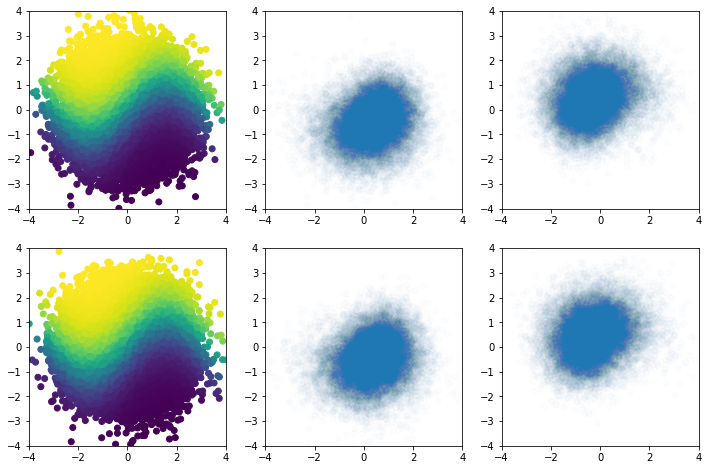

In [2]:
# simulate condition c as a function of covariates x
# add a few more covariates that aren't informative (are noise)

n_features = 3
n_examples = 40000

x = np.random.randn(n_examples, n_features)
c0_logits = 1.5 * (x[:, 1] - np.sin(x[:, 0]))
c1_logits = 1.5 * (x[:, 2] - np.sin(x[:, 1]))

def logistic(x): return 1 / (1 + np.exp(-1 * x))

c0_prob = logistic(c0_logits)
c1_prob = logistic(c1_logits)

c0 = (np.random.rand(n_examples) < c0_prob).astype(int)
c1 = (np.random.rand(n_examples) < c1_prob).astype(int)

c = np.stack([c0, c1]).T
c_prob = np.stack([c0_prob, c1_prob]).T

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, a in enumerate(ax):
    a[0].scatter(x[:, i], x[:, i + 1], c=c_prob[:, i])
    a[1].scatter(x[c[:, i] == 0, i], x[c[:, i] == 0, i + 1], alpha=.01)
    a[2].scatter(x[c[:, i] == 1, i], x[c[:, i] == 1, i + 1], alpha=.01)
    for j in range(3):
        a[j].set_xlim([-4, 4])
        a[j].set_ylim([-4, 4])

plt.show()

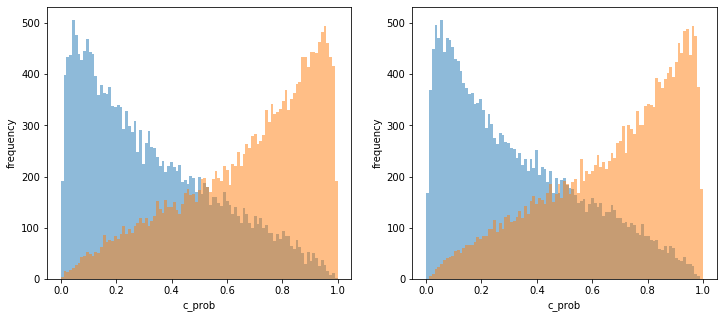

x has shape (40000, 3) 

c values
0    40018
1    39982
dtype: int64 



In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].hist(c_prob[c[:, 0] == 0, 0], bins=np.linspace(0, 1, 100), alpha=.5)
ax[0].hist(c_prob[c[:, 0] == 1, 0], bins=np.linspace(0, 1, 100), alpha=.5)
ax[1].hist(c_prob[c[:, 1] == 0, 1], bins=np.linspace(0, 1, 100), alpha=.5)
ax[1].hist(c_prob[c[:, 1] == 1, 1], bins=np.linspace(0, 1, 100), alpha=.5)
ax[0].set_xlabel('c_prob')
ax[1].set_xlabel('c_prob')
ax[0].set_ylabel('frequency')
ax[1].set_ylabel('frequency')

plt.show()

print('x has shape', np.shape(x), '\n')
print('c values')
print(pd.value_counts(c.flatten()), '\n')

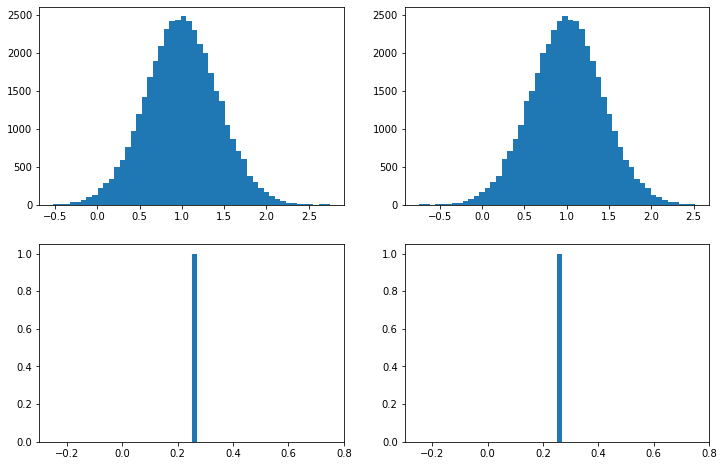

In [4]:
# simulate event times as a function of c and x with uniform censoring

max_time = 10

xmu_coeffs = np.array([[-.3, 0., .3], [.3, 0., -.3]]).T
mu_event = np.squeeze(1. + (x @ xmu_coeffs))
#xsigsq_coeffs = np.array([-.05, 0., .02])
#sigsq_event = np.squeeze(.25 + (x @ xsigsq_coeffs[:, np.newaxis]))

sigsq_event = .25

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0, 0].hist(mu_event[:, 0], bins=50)
ax[1, 0].hist(sigsq_event, bins=50)
ax[0, 1].hist(mu_event[:, 1], bins=50)
ax[1, 1].hist(sigsq_event, bins=50)
plt.show()

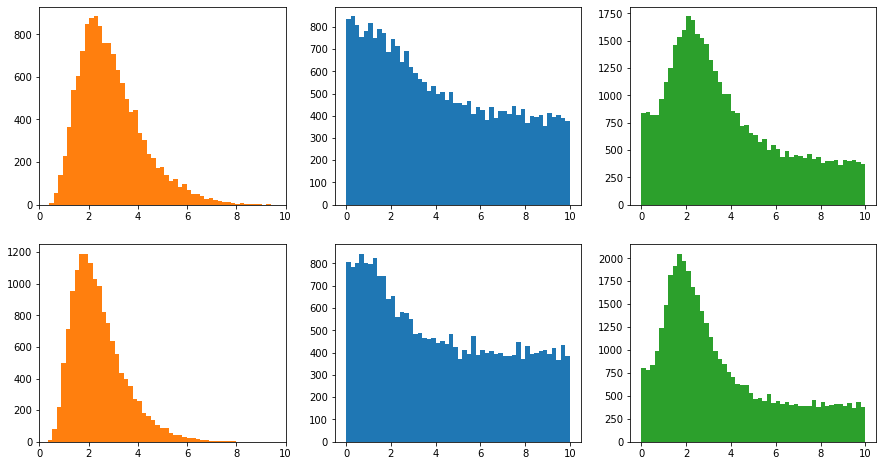

In [5]:
event_times = np.exp(mu_event + sigsq_event * np.random.randn(n_examples, 2)) + max_time * (1 - c)
censoring_times = max_time * np.random.rand(n_examples, 2)

t = np.minimum(event_times, censoring_times)
s = (t == event_times).astype(int)

fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].hist(t[s[:, 0] == 1, 0], color='C1', bins=50)
ax[0, 0].set_xlim([0, 10])
ax[0, 1].hist(t[s[:, 0] == 0, 0], color='C0', bins=50)
ax[0, 2].hist(t[:, 0], color='C2', bins=50)

ax[1, 0].hist(t[s[:, 1] == 1, 1], color='C1', bins=50)
ax[1, 0].set_xlim([0, 10])
ax[1, 1].hist(t[s[:, 1] == 0, 1], color='C0', bins=50)
ax[1, 2].hist(t[:, 1], color='C2', bins=50)

plt.show()

In [6]:
import sys
sys.path.append('../src')
from model import CFTModel

In [7]:
val_idx = 4 * n_examples // 5

x_train = x[:val_idx]
t_train = t[:val_idx]
s_train = s[:val_idx]
c_train = c[:val_idx]

x_val = x[val_idx:]
t_val = t[val_idx:]
s_val = s[val_idx:]
c_val = c[val_idx:]

Completed Epoch 0
nloglik (train) = 1.53e+00
t_mu: 6.02e-01 t_logvar: 2.91e-01
nloglik (val) = 1.29e+00
t_mu: 1.06e+00 t_logvar: 3.15e-01

Completed Epoch 10
nloglik (train) = 1.01e+00
t_mu: 1.53e+00 t_logvar: -3.47e-01
nloglik (val) = 9.77e-01
t_mu: 1.58e+00 t_logvar: -3.73e-01

Completed Epoch 20
nloglik (train) = 9.78e-01
t_mu: 1.59e+00 t_logvar: -3.41e-01
nloglik (val) = 9.73e-01
t_mu: 1.58e+00 t_logvar: -3.52e-01

Completed Epoch 30
nloglik (train) = 9.72e-01
t_mu: 1.60e+00 t_logvar: -3.30e-01
nloglik (val) = 9.67e-01
t_mu: 1.61e+00 t_logvar: -3.49e-01



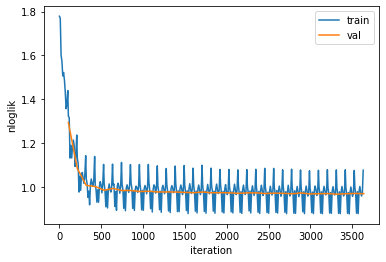

In [8]:
mdl = CFTModel(
    encoder_layer_sizes=(20,),
    decoder_layer_sizes=(20,),
    estimator='arm',
    fpr_likelihood=False,
    n_samples=50,
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = mdl.train(
        sess, x_train, t_train, s_train, x_val, t_val, s_val,
        100, max_epochs_no_improve=2, learning_rate=1e-3,
        verbose=True)
    c_pred = mdl.predict_c(sess, x_val)
    t_pred = mdl.predict_t(sess, x_val)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

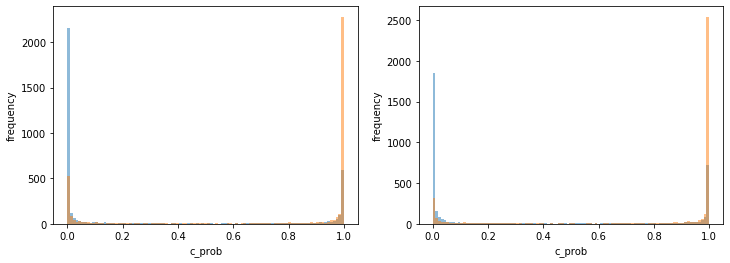

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for i, a in enumerate(ax):
    a.hist(c_pred[c_val[:, i] == 0, i], bins=np.linspace(0, 1, 100), alpha=.5)
    a.hist(c_pred[c_val[:, i] == 1, i], bins=np.linspace(0, 1, 100), alpha=.5)
    a.set_xlabel('c_prob')
    a.set_ylabel('frequency')

plt.show()

In [11]:
np.shape(c_val)

(8000, 2)

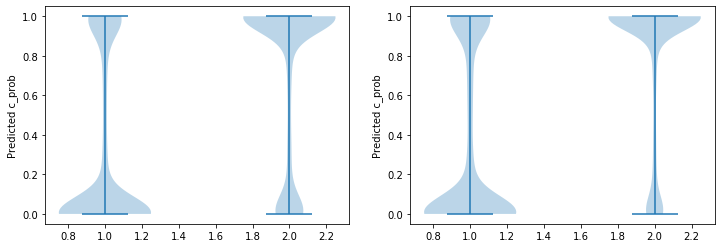

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for i, a in enumerate(ax):
    a.violinplot([c_pred[c_val[:, i] == 0, i], c_pred[c_val[:, i] == 1, i]])
    a.set_xticks([1, 2], ['c = 0', 'c = 1'])
    a.set_ylabel('Predicted c_prob')
    
plt.show()

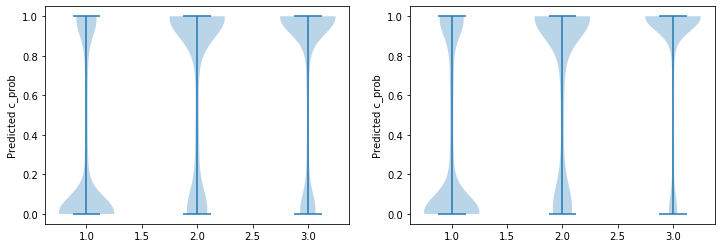

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for i, a in enumerate(ax):
    a.violinplot([
        c_pred[c_val[:, i] == 0, i],
        c_pred[(c_val[:, i] == 1) & (s_val[:, i] == 0), i],
        c_pred[(c_val[:, i] == 1) & (s_val[:, i] == 1), i]])
    a.set_xticks([1, 2, 3], ['c = 0', 'c = 1\ns = 0', 'c = 1\ns = 1'])
    a.set_ylabel('Predicted c_prob')

plt.show()

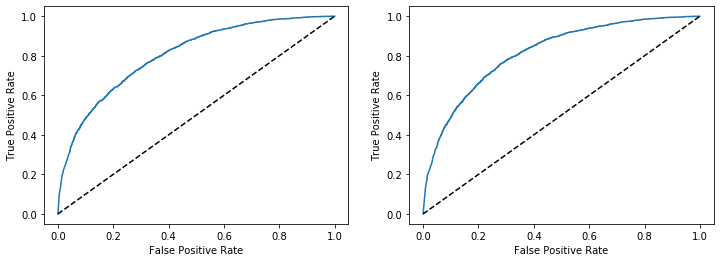

c0 AUC = 0.80
c0 Optimal AUC = 0.84
c1 AUC = 0.82
c1 Optimal AUC = 0.84


In [15]:
from sklearn.metrics import roc_curve, roc_auc_score

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for i, a in enumerate(ax):
    fpr, tpr, _ = roc_curve(c_val[:, i], c_pred[:, i])
    a.plot(fpr, tpr)
    a.plot([0, 1], [0, 1], 'k--')
    a.set_xlabel('False Positive Rate')
    a.set_ylabel('True Positive Rate')

plt.show()

print('c0 AUC = %.2f' % roc_auc_score(c_val[:, 0], c_pred[:, 0]))
print('c0 Optimal AUC = %.2f' % roc_auc_score(c_val[:, 0], c_prob[val_idx:, 0]))

print('c1 AUC = %.2f' % roc_auc_score(c_val[:, 1], c_pred[:, 1]))
print('c1 Optimal AUC = %.2f' % roc_auc_score(c_val[:, 1], c_prob[val_idx:, 1]))

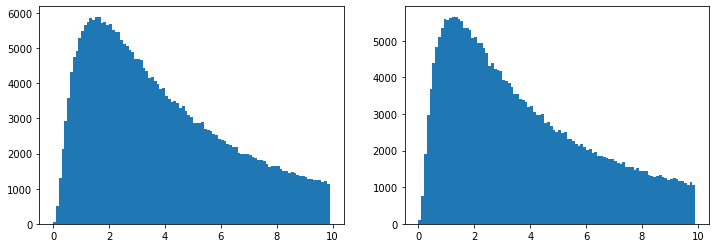

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for i, a in enumerate(ax):
    a.hist(t_pred[:, :, i].flatten(), bins=np.arange(100) / 10)

plt.show()

# Issues

- nature of penalty. is there a more principled way to choose this?
- when using NN, it will predict everyone is positive (to avoid penalty, presumably)
- dealing with variance of lognormal distribution

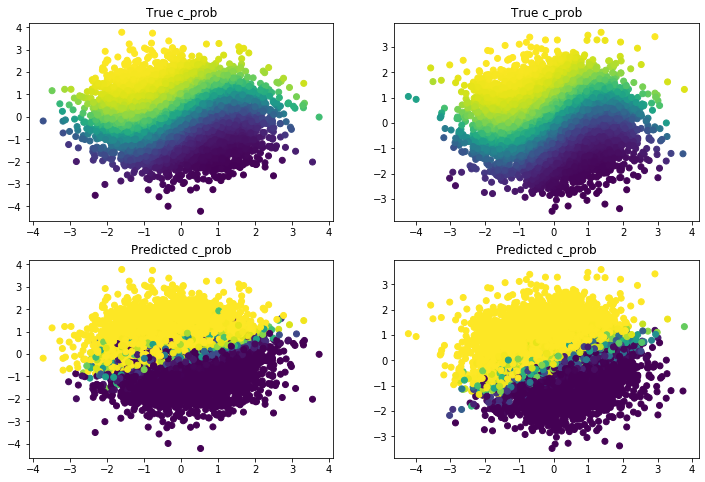

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

ax[0, 0].scatter(x_val[:, 0], x_val[:, 1], c=c_prob[val_idx:, 0])
ax[0, 0].set_title('True c_prob')

ax[1, 0].scatter(x_val[:, 0], x_val[:, 1], c=c_pred[:, 0])
ax[1, 0].set_title('Predicted c_prob')

ax[0, 1].scatter(x_val[:, 1], x_val[:, 2], c=c_prob[val_idx:, 1])
ax[0, 1].set_title('True c_prob')

ax[1, 1].scatter(x_val[:, 1], x_val[:, 2], c=c_pred[:, 1])
ax[1, 1].set_title('Predicted c_prob')

plt.show()

We know what the optimal AUC is: comes from the Bernoulli. Need to state this.

- dropout to inputs as well

- might be better to have complexity in f rather than in p(c) (put the 'load' on the decoder)

- check the logpdf

- go back to AFT model -- will show how to treat variance?

- go back to the model. how do we define penalty?

- implement the ARM

- MIMIC: find the right outcomes, pick 2-3 things, maybe more. think about competing risks versus independent
- Twitter

- calibrated. split predictions in deciles. for each group, see what proportion you get right. plot average of probabilities in that bucket. count what proportion of those in each bucket are true cases.

- can do the same for time to event. look at confidence intervals of different widths. in what proportion of cases is ground truth in that confidence interval?

- make it a little easier, make decision boundary more clear

- 10 - 20,000 tokens

- option 1: concatenate all content into long bag of tokens, then use SWEM
- option 2: embed comments and posts separately, aggregate them somehow


- create two populations, just show model can distinguish them